# Convolutional AutoEncoder Example: MINST Fashion
A repeat of the SimpleAutoEncoder example using MNIST fashion data set: https://github.com/zalandoresearch/fashion-mnist, testing the discovery of a 2-dimensional representation of the data. This time using convolutional layers.

In [1]:
# Imports
import sys
sys.path.append('../')
from BuildingBlocks import Conv2Dblock, Deconv2Dblock
from ImageAutoEncoder import ImageAutoEncoder
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Loading the fashion data set
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.fashion_mnist.load_data()
# We don't need the data to be partitioned into training and test,
# so we may as well lump it all todether:
data = np.concatenate([xtest,xtrain])/255
# Note: It's numerically helpful to put the data into the range (0,1)

### Building the Encoder

#### Encoding structure
The encoder is built by a series of **N** convolutional blocks consisting of a convolution and a pooling. To translate to the latent space, the output is then flattened and passed to a dense layer with desired latent dimension:

Input -> N x (Conv2D + Pooling) -> Flatten -> Dense (latent dims)

#### Dimensional reduction
Unlike a simple dense network, aside from the number of filters in each layer the dimensions convolutional layers cannot be controlled top-down. Instead, the heighth/width of the (in each filter/slice of the convolutional layer) is determine by the kernel (**k**) and stride (**s**) along that dimension:

o = floor((i+2p-k)/s)+1

where i is the input dimension, o is the output dimension, and p is the amount of zero-padding. A full explination of these terms and this formula can be found here: https://arxiv.org/pdf/1603.07285v1.pdf

Importantly, the floor function here means that several different input shapes can result in the same output shape (for a given kernel and stride). This will mean (see below) that the original dimensions can't always be cleanly recovered from deconvolution, another consideration when building the network.

**Note:** A pooling layer has the same dimension arithmetic as a convolution, except it's never padded (p=0), and the stride is set to the kernel "pool size" by default (s=k).

#### Conv2Dblock
This is the building block object I made for these convolutional networks. It consists of a convolution layer + pooling (either 'max', 'ave' or 'ups'). It also includes output_shape() and input_shape() methods that attempt to predict what the output/input shape of both layers together will/should be.

### Building the Decoder

#### Decode structure
The latent input requires reshaping before it can get fed into the M reverse-convolutions, so before anything it is fed into a dense layer and reshaped in order to be the right size for the first deconvolution layer. After the deconvolutions, it hopefully has the same heighth/width as the input data, and it then fed through a convolution to recover the correct number of filters (1 for bw, 3 for color).

Latent -> Dense -> Reshape -> M x reverse convolution -> Conv2D -> Output

The ImageAutoEncoder object I made allows specification of the reverse convolution blocks through the keyword param decode_blocks. If not specified, it'll attempt to build the decoder from the 'inverse' of the encoder blocks, in reverse order.

#### Reverse convolutions
There are different versions of for to reverse a convolution. At first, I was trying

- upsampling -> deconvolution

but I just made this up naively based on reversing the convolution blocks. It turns out this is redundant, since deconvolution is itself a form up upsampling. Looking around online, I see that there are 2 canonical ways to build a reverse-convolution block:

- ('upsample'): convolution -> upsampling
- ('deconv'): deconvolution -> batch normalization

and I've implemented both of these: The first by giving the Conv2Dblock an 'ups' (upsampling) pooling option, and the second by making a Deconv2Dblock object. Conv2Dblock has a attribute 'inversion' to specify which should be considered it's inverse, and an inverse() method to return the corrosponding object.

#### Dimensional madness
Like I said above, convolution input/output dimensions are not 1-to-1 thanks to the floor() function.

When building the decoder, ImageAutoEncoder will try to back-calculate the input size that needs to be fed into the decoder, then it'll construct the Dense/Reshape layers accordingly to feed from the latent space.

Very often though, there isn't a way to make this work. For a given deconvolution with kernel **k**, stride **s** and padding **p**, the output dim **o** is

o = (i-1)s+k-2p

which, if you think about it a bit, means that for (s>1), there might not be a way to scale back to the original input dimensions with a given set of pre-determined strides and kernels. So, your options are two-fold: Either be very careful selecting the parameters of the convolution layers, or design the decoder seperately.

In [3]:
# the convdim function I made in utils can help:
from utils import convdim

In [4]:
# Planning out the encoder going from 28->1
o = 28
o = convdim(convdim(o, 2, 1), 2, 2); print(o)
o = convdim(convdim(o, 2, 1), 2, 2); print(o)
o = convdim(convdim(o, 2, 1), 2, 2); print(o)
o = convdim(convdim(o, 2, 1), 1, 1); print(o)

13
6
2
1


In [5]:
# Planning out the Decoder, going from 1->28
o = 1
o = convdim(o, 3, 2, reverse=True); print(o)
o = convdim(o, 3, 2, reverse=True); print(o)
o = convdim(o, 2, 2, reverse=True); print(o)
o = convdim(o, 2, 2, reverse=True); print(o)

3
7
14
28


In [6]:
c0 = Conv2Dblock(8, (2,2), pool_size=(2,2))
c1 = Conv2Dblock(16, (2,2), pool_size=(2,2))
c2 = Conv2Dblock(32, (2,2), pool_size=(2,2))
c3 = Conv2Dblock(64, (2,2), pool_size=(1,1))
d0 = Deconv2Dblock(64, (3,3), (2,2))
d1 = Deconv2Dblock(32, (3,3), (2,2))
d2 = Deconv2Dblock(16, (2,2), (2,2))
d3 = Deconv2Dblock(8, (2,2), (2,2))
auto = ImageAutoEncoder((28,28,1), 2, [c0,c1,c2,c3],
                        decode_blocks=[d0,d1,d2,d3],
                        latent_activation='sigmoid')

In [7]:
auto.autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 27, 27, 8)         40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 16)        528       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0   

In [8]:
# Let's Train it up!
#auto.train(data, batch=10000, epochs=1)
auto.train(data, batch=1000, epochs=20)
#auto.train(data, batch=100, epochs=20)

Epoch 1/20
70/70 [==============================] - 33s 454ms/step - loss: 0.6480 - accuracy: 0.3270
Epoch 2/20
70/70 [==============================] - 34s 486ms/step - loss: 0.5311 - accuracy: 0.4414
Epoch 3/20
70/70 [==============================] - 34s 483ms/step - loss: 0.4490 - accuracy: 0.4798
Epoch 4/20
70/70 [==============================] - 34s 485ms/step - loss: 0.4052 - accuracy: 0.4880
Epoch 5/20
70/70 [==============================] - 36s 517ms/step - loss: 0.3837 - accuracy: 0.4917
Epoch 6/20
70/70 [==============================] - 34s 483ms/step - loss: 0.3715 - accuracy: 0.4938
Epoch 7/20
70/70 [==============================] - 35s 495ms/step - loss: 0.3664 - accuracy: 0.4930
Epoch 8/20
70/70 [==============================] - 35s 493ms/step - loss: 0.3604 - accuracy: 0.4944
Epoch 9/20
70/70 [==============================] - 34s 493ms/step - loss: 0.3576 - accuracy: 0.4941
Epoch 10/20
70/70 [==============================] - 35s 499ms/step - loss: 0.3553 - accura

**A word on training:** Unlike the simpler version of the autoencoder, here larger batch sizes seem to do slightly better?

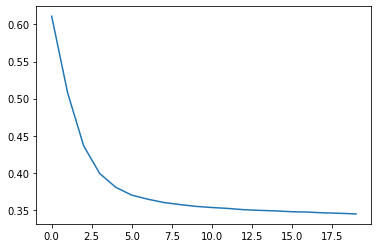

In [10]:
plt.plot(auto.loss)

### Visialization

In [9]:
# Obtaining a transformed copy of the data
transformed = auto.autoencoder.predict(data)

#### Fig 1: A selection of images from the set, next to the result of encoding/decoding them

Text(0, 0.5, 'Encoded/Decoded')

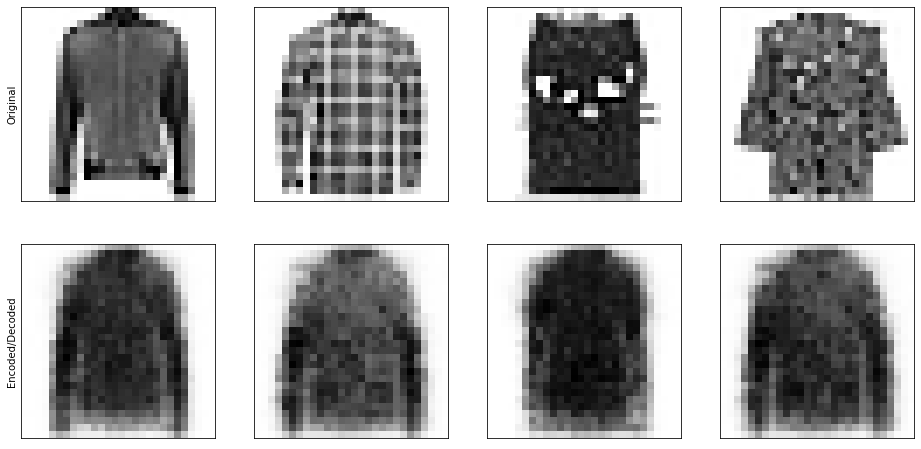

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(16,8), sharex=True, sharey=True)
for i in range(4):
    im = np.random.randint(0, data.shape[0])
    axs[0][i].imshow(data[im,:], cmap='Greys', interpolation='none')
    axs[1][i].imshow(transformed[im,:], cmap='Greys', interpolation='none')
    axs[0][i].set_xticks([]); axs[0][i].set_yticks([])
    axs[1][i].set_xticks([]); axs[1][i].set_yticks([])
axs[0][0].set_ylabel("Original"); axs[1][0].set_ylabel("Encoded/Decoded")

#### Fig 2: Spread of the decoded latent space

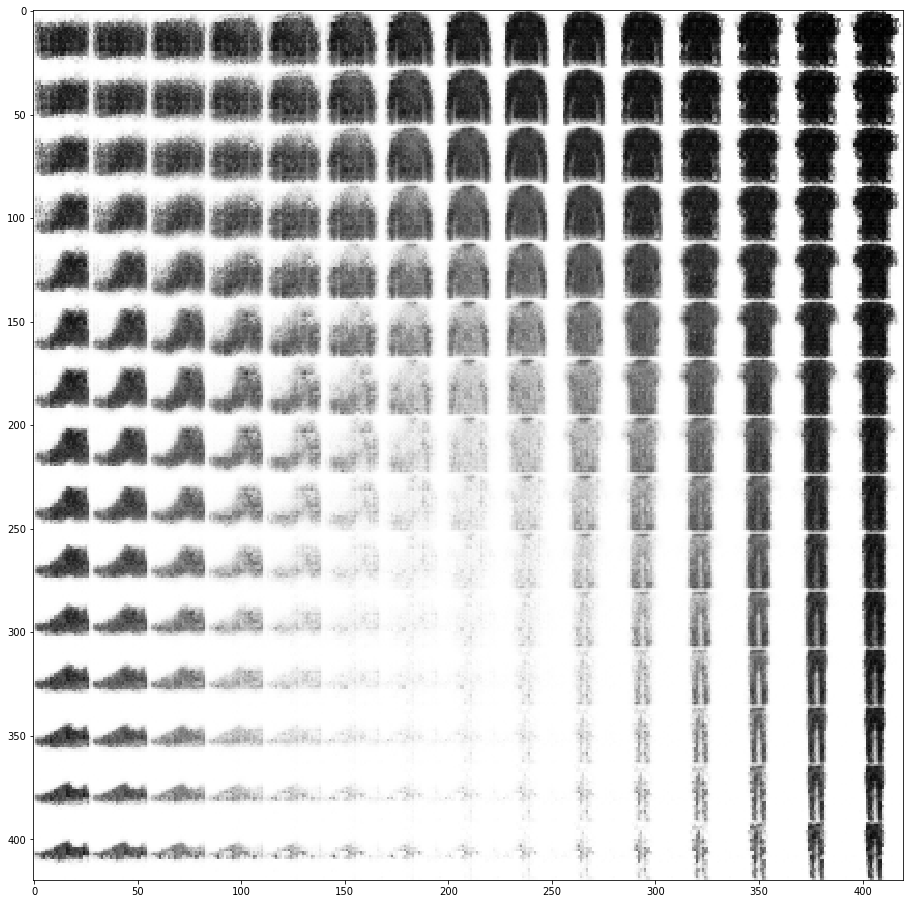

In [12]:
# Here is our spread of the results for a 2D sample space
nside = 15
x = np.linspace(0,1,num=nside)
x, y = np.meshgrid(x,x)
coords = np.array([x.flatten(), y.flatten()]).transpose()
simg = auto.Decode(coords)
image = np.zeros((28*nside,28*nside)); n=0
for i in range(nside):
    for j in range(nside):
        image[28*i:28*(i+1),28*j:28*(j+1)] = np.reshape(simg[n,:],(28,28))
        n += 1
fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(image, cmap='Greys', interpolation='none')

#### Fig 3: The distribution of latent-space representations of images.

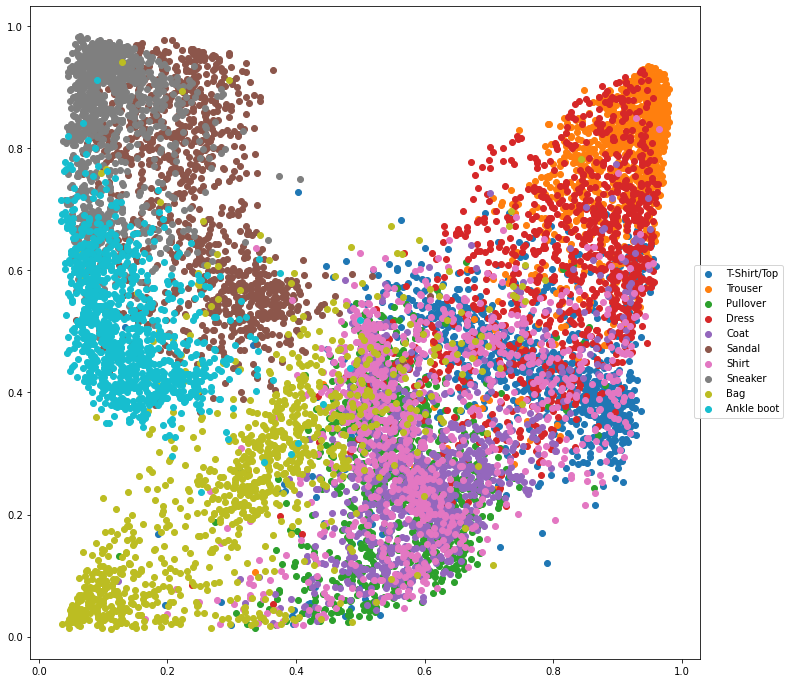

In [13]:
# To scatterplot the latent space distribution of different items
a = []
for i in range(10):
    a.append(auto.Encode(data[np.where(ytest==i)[0],:]))
a = np.array(a)
label_key = {0:"T-Shirt/Top",1:"Trouser",2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",6:"Shirt",
    7:"Sneaker",8:"Bag",9:"Ankle boot"}
fig, ax = plt.subplots(figsize=(12,12))
for i in range(10):
    ax.scatter(a[i,:,0],a[i,:,1], label=label_key[i])
fig.legend(loc='right')

## Conclusions
On the whole this model does OK, though I don't see a whole lot of improvement from the SimpleAutoEncoder in this exact case. On the other hand, it does an OK job with ~2 orders of magnitude fewer trainable parameters (3,700,000 params in the simple autoencoder, versus 69,000 here).

Although it's less pronounced in this particular example, one common quirk I've seen here is that the decoded images often have a 'blocky' quality to them from the deconvolution layers. I haven't really figured out how to fix this, although It would seem to be solvable by finetuning the geometry of the decoder.

Like the simple auto-encoder, this model struggles to reproduce the images with any detail (the above is the absolute best I could get it to do). This is likely just because the bottleneck of dim=2 is a little too tight. It could be interesting to see how much better it does with a slightly larger latent space.

I notice that the solution the model trains too can be wildy different from trial to trial, even with the same parameters, which suggests the gradient space is very rough, with a lot of high peaks and valleys. This in turn suggests that a better/optimal solution could available by playing with the exact way the model is trained (not to mention trying out different learning rate schedules) --- trying to converge it better on the universal minimum of the loss function. I wanted to stick to the simplest training regime here, but I believe this is worth investigating in the future.

Finally, I notice that the image catagories are not always well separated in the latent space (although it looks OK in the example above). That said, It's notable that, unlike the SimpleAutoEncoder, this version of the autoencoder almost never colapses to the 'linear' solution. I wonder if there is a way to force different image catagories to form more distinct clusters in the latent space, perhaps by some additional term in the loss function. (This sort of idea might be similar in concept to the the way a variational autoencoder works, so we'll have to see when I study those.)